In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib import style
from itertools import cycle
from sklearn.decomposition import PCA


style.use("default")
plt.rcParams['figure.dpi'] = 300

In [10]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import time

def cal_pairwise_dist(x):
    '''计算pairwise 距离, x是matrix
    (a-b)^2 = a^2 + b^2 - 2*a*b
    '''
    sum_x = np.sum(np.square(x), 1)
    dist = np.add(np.add(-2 * np.dot(x, x.T), sum_x).T, sum_x)
    #返回任意两个点之间距离的平方
    return dist

def cal_perplexity(dist, idx=0, beta=1.0):
    '''计算perplexity, D是距离向量，
    idx指dist中自己与自己距离的位置，beta是高斯分布参数
    这里的perp仅计算了熵，方便计算
    '''
    prob = np.exp(-dist * beta)
    # 设置自身prob为0
    prob[idx] = 0
    sum_prob = np.sum(prob)
    if sum_prob < 1e-12:
        prob = np.maximum(prob, 1e-12)
        perp = -12
    else:
        perp = np.log(sum_prob) + beta * np.sum(dist * prob) / sum_prob
        prob /= sum_prob

    return perp, prob

def seach_prob(x, tol=1e-5, perplexity=30.0):
    '''二分搜索寻找beta,并计算pairwise的prob
    '''

    # 初始化参数
    print("Computing pairwise distances...")
    (n, d) = x.shape
    dist = cal_pairwise_dist(x)
    dist[dist < 0] = 0
    pair_prob = np.zeros((n, n))
    beta = np.ones((n, 1))
    # 取log，方便后续计算
    base_perp = np.log(perplexity)

    for i in range(n):
        if i % 500 == 0:
            print("Computing pair_prob for point %s of %s ..." %(i,n))

        betamin = -np.inf
        betamax = np.inf
        perp, this_prob = cal_perplexity(dist[i], i, beta[i])

        # 二分搜索,寻找最佳sigma下的prob
        perp_diff = perp - base_perp
        tries = 0
        while np.abs(perp_diff) > tol and tries < 50:
            if perp_diff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2
                else:
                    beta[i] = (beta[i] + betamin) / 2

            # 更新perb,prob值
            perp, this_prob = cal_perplexity(dist[i], i, beta[i])
            perp_diff = perp - base_perp
            tries = tries + 1
        # 记录prob值
        pair_prob[i,] = this_prob
    print("Mean value of sigma: ", np.mean(np.sqrt(1 / beta)))
    #每个点对其他点的条件概率分布pi\j
    return pair_prob

def tsne(x, no_dims=2, perplexity=30.0, max_iter=1000):
    """Runs t-SNE on the dataset in the NxD array x
    to reduce its dimensionality to no_dims dimensions.
    The syntaxis of the function is Y = tsne.tsne(x, no_dims, perplexity),
    where x is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array x should have type float.")
        return -1

    (n, d) = x.shape

    # 动量
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    # 随机初始化Y
    y = np.random.randn(n, no_dims)
    # dy梯度
    dy = np.zeros((n, no_dims))
    # iy是什么
    iy = np.zeros((n, no_dims))

    gains = np.ones((n, no_dims))

    # 对称化
    P = seach_prob(x, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)   #pij
    # early exaggeration
    # pi\j，提前夸大
    print ("T-SNE DURING:%s" % time.clock())
    P = P * 4
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):
        # Compute pairwise affinities
        sum_y = np.sum(np.square(y), 1)
        num = 1 / (1 + np.add(np.add(-2 * np.dot(y, y.T), sum_y).T, sum_y))
        num[range(n), range(n)] = 0
        Q = num / np.sum(num)   #qij
        Q = np.maximum(Q, 1e-12)    #X与Y逐位比较取其大者

        # Compute gradient
        # np.tile(A,N) 重复数组AN次 [1],5 [1,1,1,1,1]
        # pij-qij
        PQ = P - Q
        # 梯度dy
        for i in range(n):
            dy[i,:] = np.sum(np.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (y[i,:] - y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum

        gains = (gains + 0.2) * ((dy > 0) != (iy > 0)) + (gains * 0.8) * ((dy > 0) == (iy > 0))
        gains[gains < min_gain] = min_gain
        # 迭代
        iy = momentum * iy - eta * (gains * dy)
        y = y + iy
        y = y - np.tile(np.mean(y, 0), (n, 1))
        # Compute current value of cost function\
        if (iter + 1) % 100 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration ", (iter + 1), ": error is ", C)
            if (iter+1) != 100:
                ratio = C/oldC
                print("ratio ", ratio)
                if ratio >= 0.95:
                    break
            oldC = C
        # Stop lying about P-values
        if iter == 100:
            P = P / 4
    print("finished training!")
    return y


In [3]:
    digits = load_digits()
    X = digits.data
    Y = digits.target

    data_2d = tsne(X, 2)
    plt.scatter(data_2d[:, 0], data_2d[:, 1], c = Y)
    plt.show()

Computing pairwise distances...
Computing pair_prob for point 0 of 1797 ...
Computing pair_prob for point 500 of 1797 ...
Computing pair_prob for point 1000 of 1797 ...
Computing pair_prob for point 1500 of 1797 ...
Mean value of sigma:  11.698543429042957


AttributeError: module 'time' has no attribute 'clock'

In [5]:
data = pd.read_table("./AfterLI/zeropadding/2D_zeropadding.csv",delimiter=";", header = 0)
data

,50,52,54,56,58,60,62,64,66,68,...,1734,1736,1738,1740,1742,1744,1746,1748,1750,Target
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,0.017849,0.005737,0.000000,0.003900,0.023554,0.031535,0.026788,0.022345,0.024567,0.028440,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
567,0.008550,0.000000,0.005080,0.022874,0.043871,0.059300,0.064361,0.067193,0.069605,0.072867,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
568,0.005271,0.000000,0.006097,0.020630,0.065819,0.098742,0.104104,0.102023,0.104814,0.102508,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
569,0.003967,0.000000,0.004454,0.013279,0.026271,0.041341,0.052007,0.055192,0.056522,0.057099,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6


<Figure size 1500x900 with 0 Axes>

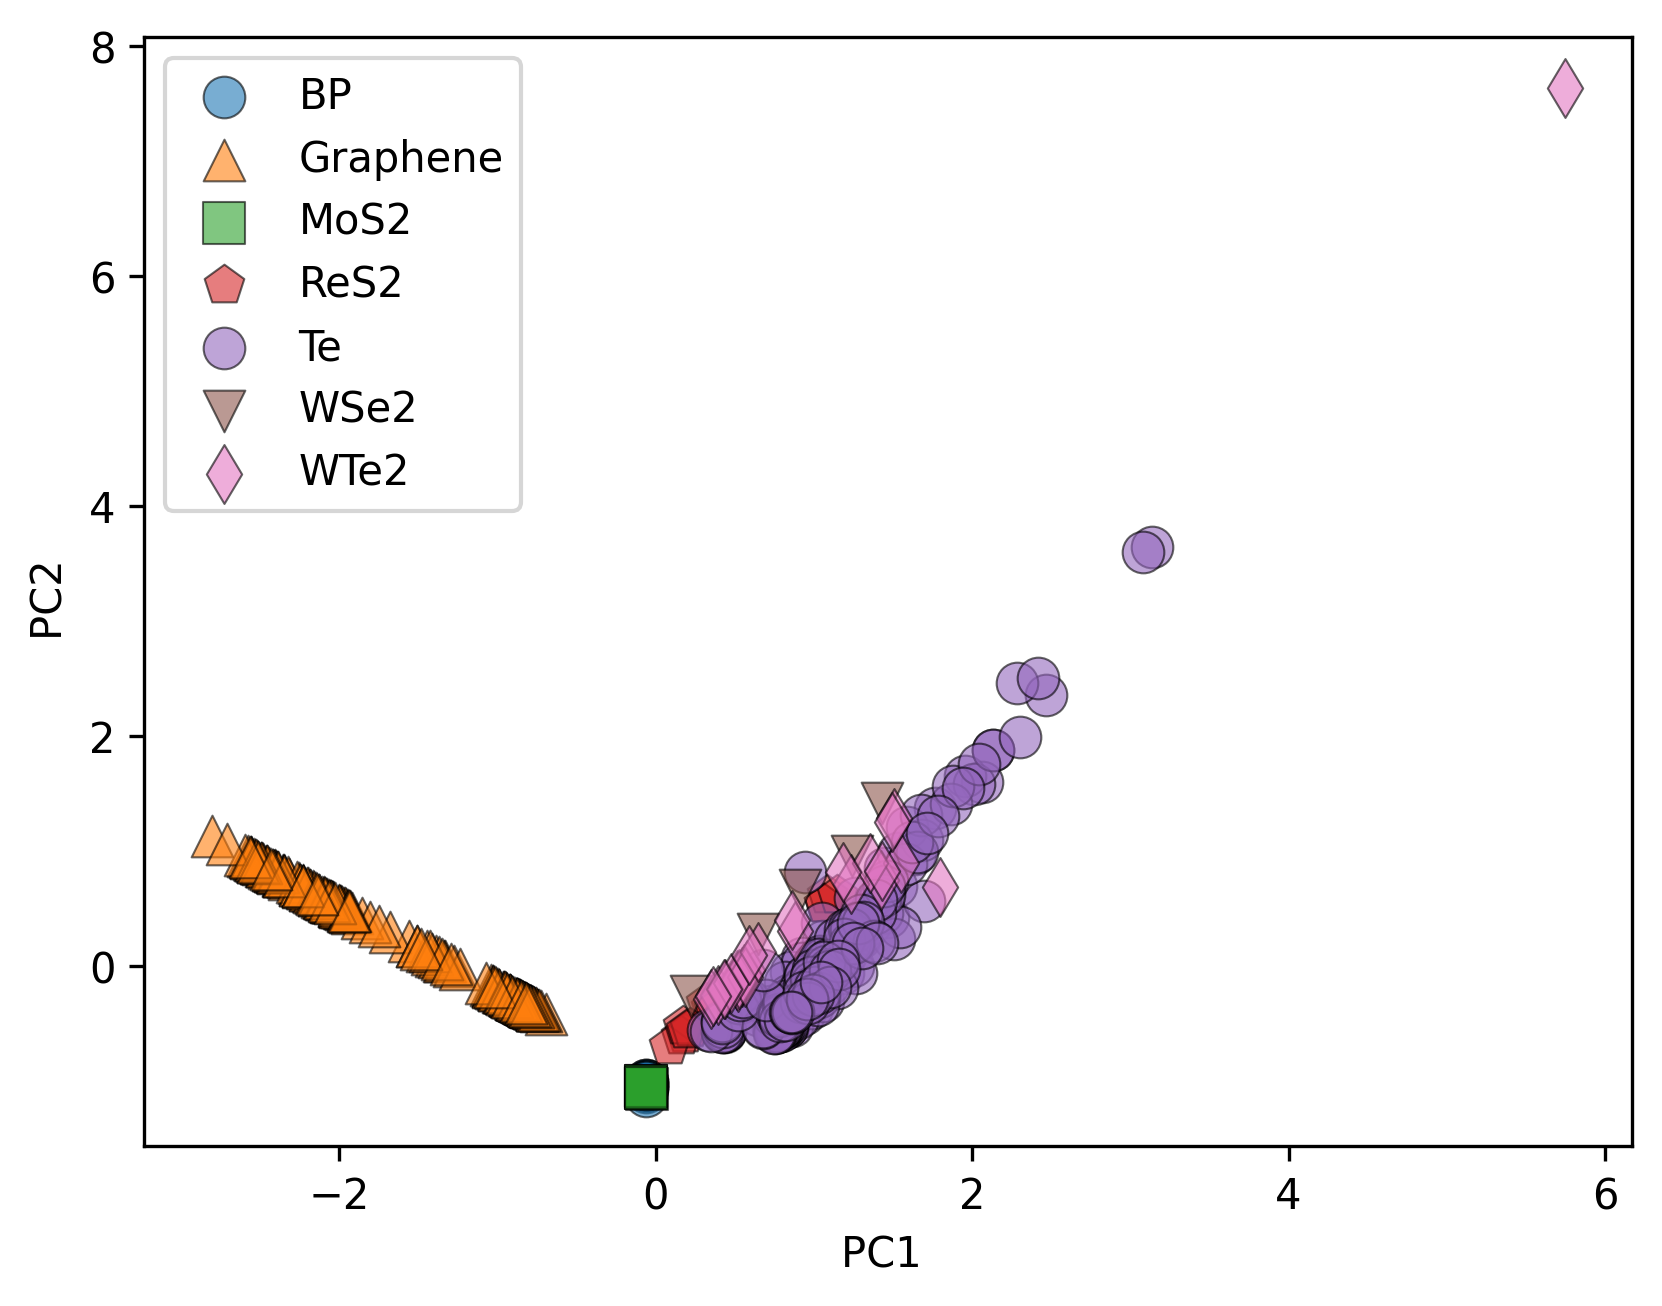

<Figure size 1500x900 with 0 Axes>

In [14]:
X_scaled, Y = np.array(data.iloc[:,0:-1]),np.asarray(data.iloc[:,-1])
shapes = cycle(["o", "^", "s", "d", "v", "p", "P", "*", "<", ">"])
pca = PCA(n_components=2)

pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

# plt.scatter(X_pca[0:5, 0], X_pca[0:5, 1],label = "SLG", marker="o", edgecolors="k", linewidths=0.5,alpha=0.6,s=100)
# plt.scatter(X_pca[6:70, 0], X_pca[6:70, 1],label = "0-9°", marker="^", edgecolors="k", linewidths=0.5,alpha=0.6,s=100)
# plt.scatter(X_pca[71:98, 0], X_pca[71:98, 1],label = "9-20°", marker="s", edgecolors="k", linewidths=0.5,alpha=0.6,s=100)
# plt.scatter(X_pca[99:208, 0], X_pca[99:208, 1],label = "20-30°", marker="p", edgecolors="k", linewidths=0.5,alpha=0.6,s=100)

plt.scatter(X_pca[0:34, 0], X_pca[0:34, 1],label = "BP", marker="o", edgecolors="k", linewidths=0.5,alpha=0.6,s=100)
plt.scatter(X_pca[35:243, 0], X_pca[35:243, 1],label = "Graphene", marker="^", edgecolors="k", linewidths=0.5,alpha=0.6,s=100)
plt.scatter(X_pca[244:251, 0], X_pca[244:251, 1],label = "MoS2", marker="s", edgecolors="k", linewidths=0.5,alpha=0.6,s=100)
plt.scatter(X_pca[252:266, 0], X_pca[252:266, 1],label = "ReS2", marker="p", edgecolors="k", linewidths=0.5,alpha=0.6,s=100)
plt.scatter(X_pca[267:536, 0], X_pca[267:536, 1],label = "Te", marker="o", edgecolors="k", linewidths=0.5,alpha=0.6,s=100)
plt.scatter(X_pca[537:542, 0], X_pca[537:542, 1],label = "WSe2", marker="v", edgecolors="k", linewidths=0.5,alpha=0.6,s=100)
plt.scatter(X_pca[543:570, 0], X_pca[543:570, 1],label = "WTe2", marker="d", edgecolors="k", linewidths=0.5,alpha=0.6,s=100)


plt.xlabel(f"PC1 ")
plt.ylabel(f"PC2 ")
plt.legend()
plt.figure(figsize=(5,3))

<Figure size 1500x900 with 0 Axes>

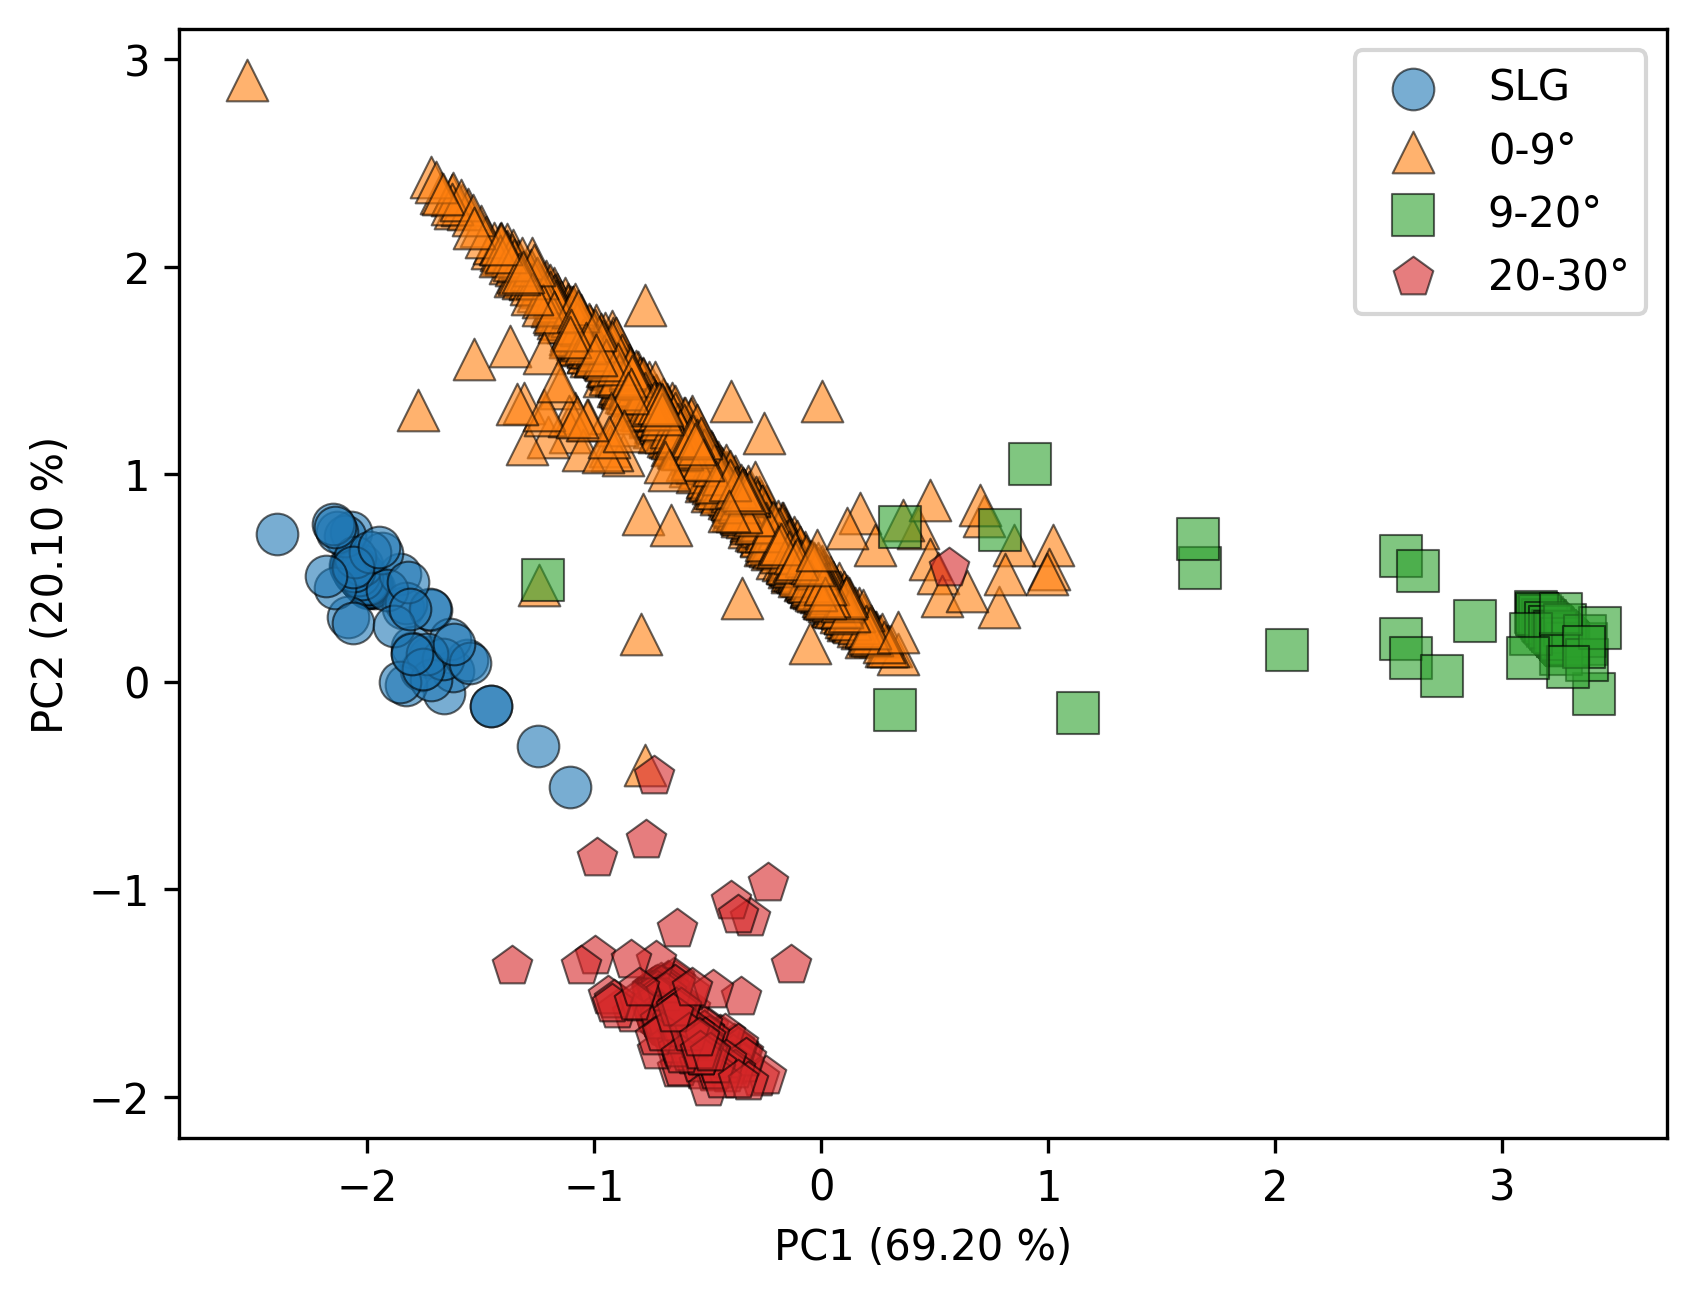

<Figure size 1500x900 with 0 Axes>

In [3]:
data = pd.read_table("Normtotal.csv",delimiter=";",skiprows=0, header = None)
X_scaled, Y = np.array(data.iloc[:,0:-1]),np.asarray(data.iloc[:,-1])
shapes = cycle(["o", "^", "s", "d", "v", "p", "P", "*", "<", ">"])
pca = PCA(n_components=2)

pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

plt.scatter(X_pca[0:1047, 0], X_pca[0:1047, 1],label = "SLG", marker="o", edgecolors="k", linewidths=0.5,alpha=0.6,s=100)
plt.scatter(X_pca[1048:2112, 0], X_pca[1048:2112, 1],label = "0-9°", marker="^", edgecolors="k", linewidths=0.5,alpha=0.6,s=100)
plt.scatter(X_pca[2113:3140, 0], X_pca[2113:3140, 1],label = "9-20°", marker="s", edgecolors="k", linewidths=0.5,alpha=0.6,s=100)
plt.scatter(X_pca[3141:4250, 0], X_pca[3141:4250, 1],label = "20-30°", marker="p", edgecolors="k", linewidths=0.5,alpha=0.6,s=100)


plt.xlabel(f"PC1 ({(pca.explained_variance_ratio_[0] * 100):.2f} %)")
plt.ylabel(f"PC2 ({(pca.explained_variance_ratio_[1] * 100):.2f} %)")
plt.legend()
plt.figure(figsize=(5,3))

<Figure size 1500x900 with 0 Axes>

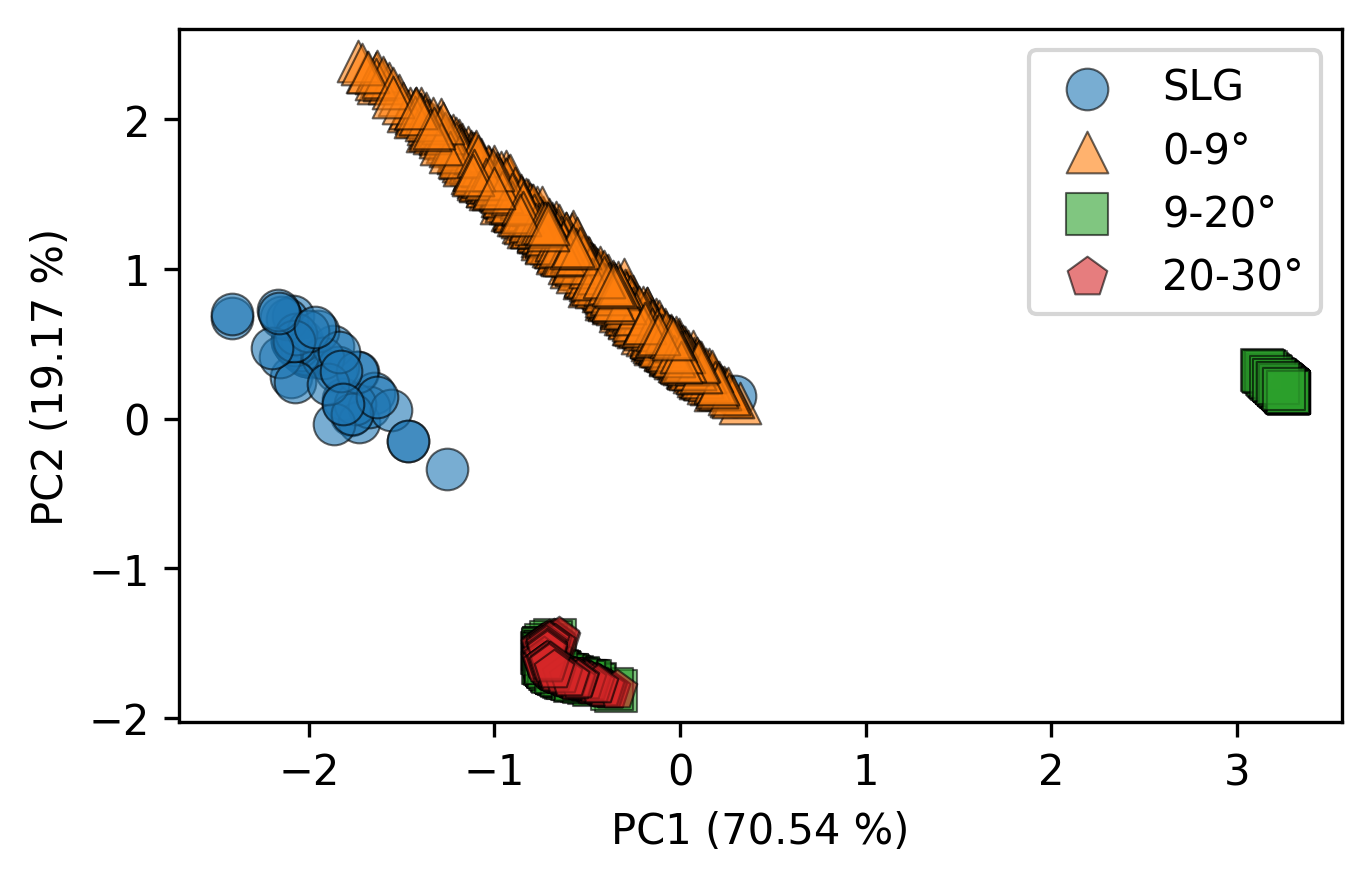

<Figure size 1500x900 with 0 Axes>

In [2]:
plt.figure(figsize=(5, 3))
data = pd.read_table("Normexceptraw.csv", delimiter=";", skiprows=0, header=None)
X_scaled, Y = np.array(data.iloc[:, 0:-1]), np.asarray(data.iloc[:, -1])
shapes = cycle(["o", "^", "s", "d", "v", "p", "P", "*", "<", ">"])
pca = PCA(n_components=2)

pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

plt.scatter(X_pca[0:1047, 0], X_pca[0:1047, 1], label="SLG", marker="o", edgecolors="k", linewidths=0.5, alpha=0.6,
            s=100)
plt.scatter(X_pca[1048:2112, 0], X_pca[1048:2112, 1], label="0-9°", marker="^", edgecolors="k", linewidths=0.5,
            alpha=0.6, s=100)
plt.scatter(X_pca[2113:3140, 0], X_pca[2113:3140, 1], label="9-20°", marker="s", edgecolors="k", linewidths=0.5,
            alpha=0.6, s=100)
plt.scatter(X_pca[3141:4250, 0], X_pca[3141:4250, 1], label="20-30°", marker="p", edgecolors="k", linewidths=0.5,
            alpha=0.6, s=100)

plt.xlabel(f"PC1 ({(pca.explained_variance_ratio_[0] * 100):.2f} %)")
plt.ylabel(f"PC2 ({(pca.explained_variance_ratio_[1] * 100):.2f} %)")
plt.legend()
plt.figure(figsize=(5, 3))

<Figure size 1500x900 with 0 Axes>

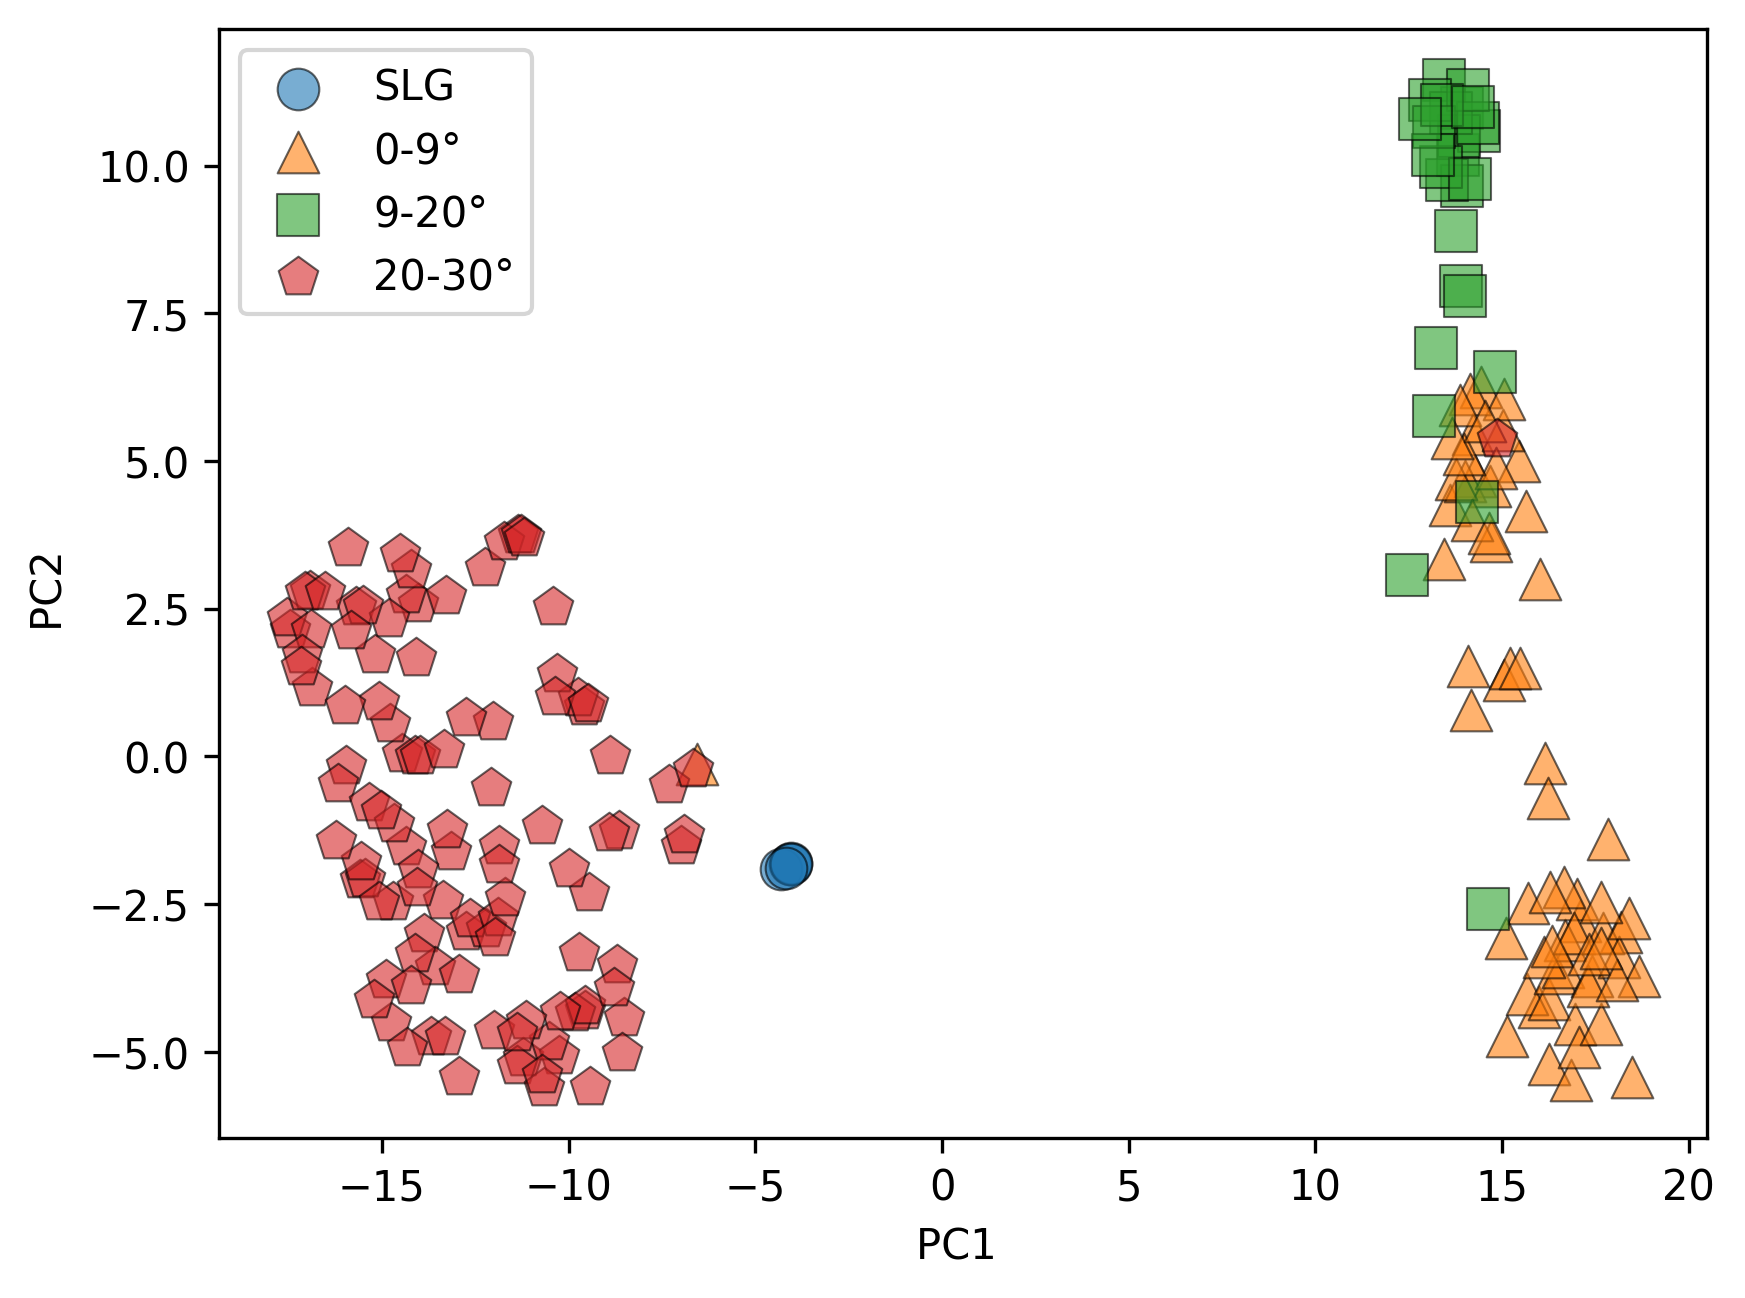

<Figure size 1500x900 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import manifold
import numpy as np
ts = manifold.TSNE(n_components=2, init='pca', random_state=0)

data = pd.read_table("./dataset/Normraw.csv",delimiter=";",skiprows=0, header = None)
X_scaled, Y = np.array(data.iloc[:,0:-1]),np.asarray(data.iloc[:,-1])
shapes = cycle(["o", "^", "s", "d", "v", "p", "P", "*", "<", ">"])
pca = PCA(n_components=2)

ts.fit(X_scaled)
X_pca = ts.fit_transform(X_scaled)

# plt.scatter(X_pca[0:5, 0], X_pca[0:5, 1],label = "SLG", marker="o", edgecolors="k", linewidths=0.5,alpha=0.6,s=100)
# plt.scatter(X_pca[6:70, 0], X_pca[6:70, 1],label = "0-9°", marker="^", edgecolors="k", linewidths=0.5,alpha=0.6,s=100)
# plt.scatter(X_pca[71:98, 0], X_pca[71:98, 1],label = "9-20°", marker="s", edgecolors="k", linewidths=0.5,alpha=0.6,s=100)
# plt.scatter(X_pca[99:208, 0], X_pca[99:208, 1],label = "20-30°", marker="p", edgecolors="k", linewidths=0.5,alpha=0.6,s=100)

plt.scatter(X_pca[0:5, 0], X_pca[0:5, 1],label = "SLG", marker="o", edgecolors="k", linewidths=0.5,alpha=0.6,s=100)
plt.scatter(X_pca[6:70, 0], X_pca[6:70, 1],label = "0-9°", marker="^", edgecolors="k", linewidths=0.5,alpha=0.6,s=100)
plt.scatter(X_pca[71:98, 0], X_pca[71:98, 1],label = "9-20°", marker="s", edgecolors="k", linewidths=0.5,alpha=0.6,s=100)
plt.scatter(X_pca[99:208, 0], X_pca[99:208, 1],label = "20-30°", marker="p", edgecolors="k", linewidths=0.5,alpha=0.6,s=100)

plt.xlabel(f"PC1 ")
plt.ylabel(f"PC2 ")
plt.legend()
plt.figure(figsize=(5,3))
